# Test 5: Parallel computing on a data set opened with a reference file

This notebook seeks to confirm that parallel computing on both a local and distributed cluster works as expected on a dataset open with a kerchunk reference file. The notebook first creates a combined reference file for one year of MUR 0.01 degree data, then computes the mean seasonal cycle off the U.S.A. west coast using parallel computing. For parallel computing, a local dask cluster is used, then a distributed Dask cluster via Coiled. For comparison, using a Dask local cluster on the dataset loaded from the native netCDF files is also used.

The reference files are created using kerchunk and earthaccess is used to access NASA Earthdata.

#### Results
The combined reference file is created in a few minutes with the help of Coiled for parallel computing. The dataset open with the reference file is used successfully with a Dask local cluster, reducing the SST seasonal cycle computation time by half. However, the dataset opened with the reference file is failing for parallel computing with a distributed cluster via Coiled. There seems to be file not found errors and key errors. Maybe each VM needs the reference file locally?

## Install packages

To install kerchunk, used
```
!pip install git+https://github.com/fsspec/kerchunk

```

In [1]:
import os
import fsspec
import kerchunk
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
import ujson
import xarray as xr
import earthaccess
import coiled
import multiprocessing
from dask.distributed import Client
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
earthaccess.login()
shortname = "MUR-JPL-L4-GLOB-v4.1"
granule_info = earthaccess.search_data(
    short_name=shortname,
    #temporal=("2019-01-01", "2019-12-31"),
    count=(365)
    )

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


Granules found: 8088


In [3]:
fobjs = earthaccess.open(granule_info)

Opening 365 granules, approx size: 121.88 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/365 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/365 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/365 [00:00<?, ?it/s]

# 1. Create a combined reference file for first year of MUR 0.01 degree data

In [4]:
## Store reference JSONs in these directories:
dir_refs_indv = './reference_jsons_individual/'
dir_refs_comb = './reference_jsons_combined/'

In [5]:
!mkdir $dir_refs_indv
!mkdir $dir_refs_comb

In [6]:
def single_ref_earthaccess(fobj):
    """
    Inputs
    ------
    fobj: earthaccess.store.EarthAccessFile object
        Obtained from a call to earthaccess.open().
    """
    endpoint = fobj.full_name
    reference = SingleHdf5ToZarr(fobj, endpoint, inline_threshold=0).translate()
    return reference, endpoint # returns both the kerchunk reference and the path the file on podaac-ops-cumulus-protected

In [7]:
%%time

## --------------------------------------------
## Create single reference files with parallel computing using Coiled
## --------------------------------------------

# Wrap `create_single_ref` into coiled function:
single_ref_earthaccess_par = coiled.function(
    region="us-west-2", spot_policy="on-demand", 
    vm_type="m6i.large", n_workers=50
    )(single_ref_earthaccess)

# Begin computations:
fobjs_process = fobjs[:365]
results = single_ref_earthaccess_par.map(fobjs_process)

# Save results to JSONs as they become available:
for reference, endpoint in results:
    name_ref = dir_refs_indv + endpoint.split('/')[-1].replace('.nc', '.json')
    with open(name_ref, 'w') as outf:
        outf.write(ujson.dumps(reference))

single_ref_earthaccess_par.cluster.shutdown()

Output()

╭──────────────────────────────── Package Info ────────────────────────────────╮
│            ╷                                                                 │
│   Package  │ Note                                                            │
│ ╶──────────┼───────────────────────────────────────────────────────────────╴ │
│   kerchunk │ Wheel built from                                                │
│            │ /opt/coiled/env/.path-deps/kerchunk-0.2.5.post5-py3-none-any.   │
│            │ whl                                                             │
│            ╵                                                                 │
╰──────────────────────────────────────────────────────────────────────────────╯

Output()

CPU times: user 3.67 s, sys: 252 ms, total: 3.92 s
Wall time: 1min 48s


In [8]:
## --------------------------------------------
## Prep work for the combined reference file
## --------------------------------------------

## Get AWS creds from first file-object in the list:
remote_options = {"anon": False, "key": fobjs[0].f.s3.key, "secret": fobjs[0].f.s3.secret, "token": fobjs[0].f.s3.token}

example_data = xr.open_dataset(fobjs[0])
dims_nottime = list(example_data.dims.keys())
dims_nottime.remove('time')
print(dims_nottime)

['lat', 'lon']


/tmp/ipykernel_150/3880894143.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dims_nottime = list(example_data.dims.keys())


In [9]:
%%time

## --------------------------------------------
## Create combined reference file
## --------------------------------------------

ref_files_indv = [dir_refs_indv+f for f in os.listdir(dir_refs_indv) if f.endswith('.json')]
ref_files_indv.sort()
print(ref_files_indv[:5])

## Combined reference file
mzz = MultiZarrToZarr(
    ref_files_indv,
    remote_protocol="s3",
    remote_options=remote_options,
    concat_dims=["time"], 
    identical_dims=dims_nottime
    )
ref_combined = mzz.translate()

 # Save reference info to JSON:
name_refcombined = dir_refs_comb + shortname + "_combined.json"
with open(name_refcombined, 'wb') as outf:
    outf.write(ujson.dumps(ref_combined).encode())

['./reference_jsons_individual/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.json', './reference_jsons_individual/20020602090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.json', './reference_jsons_individual/20020603090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.json', './reference_jsons_individual/20020604090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.json', './reference_jsons_individual/20020605090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.json']
CPU times: user 6.06 s, sys: 366 ms, total: 6.42 s
Wall time: 38.2 s


In [10]:
%%time

## --------------------------------------------
## Test combined reference file
## --------------------------------------------

name_refcombined = dir_refs_comb + shortname + "_combined.json"
data = xr.open_dataset(
    "reference://", engine="zarr", chunks={},
    backend_kwargs={
        "storage_options": {
            "fo": name_refcombined,
            "remote_protocol": "s3",
            "remote_options": remote_options
            },
        "consolidated": False
        }
)
data

CPU times: user 1.34 s, sys: 116 ms, total: 1.45 s
Wall time: 1.75 s


<xarray.Dataset> Size: 7TB
Dimensions:           (time: 365, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 3kB 2002-06-01T09:00:00 ... 2003-...
Data variables:
    analysed_sst      (time, lat, lon) float64 2TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 2TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 946GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.5
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20020601T210000Z
    time_coverage_start:        20020531T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [11]:
data.close()
del data

## 2. Using parallel computing on the dataset opened with the reference file

## 2.1 Using Dask local cluster

In [ ]:
# Credentials for opening the dataset with the reference file:
s3creds = earthaccess.get_s3_credentials(daac='PODAAC')

In [17]:
%%time

## --------------------------------------------
## Open dataset with reference file
## --------------------------------------------

data = xr.open_dataset(
    "reference://", engine="zarr", chunks={},
    backend_kwargs={
        "storage_options": {
            "fo": dir_refs_comb + shortname + "_combined.json",
            "remote_protocol": "s3",
            "remote_options": {
                "anon":False, "key": s3creds['accessKeyId'], 
                "secret": s3creds['secretAccessKey'], 
                "token": s3creds['sessionToken']
                }
            },
        "consolidated": False
        }
)
sst = data['analysed_sst']
sst = sst.chunk(chunks={'lat': 300, 'lon': 300, 'time': 200})
sst

CPU times: user 4.18 s, sys: 196 ms, total: 4.38 s
Wall time: 4.64 s


<xarray.DataArray 'analysed_sst' (time: 365, lat: 17999, lon: 36000)> Size: 2TB
dask.array<rechunk-merge, shape=(365, 17999, 36000), dtype=float64, chunksize=(200, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon      (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 3kB 2002-06-01T09:00:00 ... 2003-05-31T09:...
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [18]:
multiprocessing.cpu_count()

32

In [19]:
## Local Dask Cluster
client = Client(n_workers=16, threads_per_worker=1)
print(client.cluster)
client.dashboard_link

LocalCluster(1847ada5, 'tcp://127.0.0.1:38599', workers=16, threads=16, memory=122.35 GiB)


'https://cluster-onvfl.dask.host/jupyter/proxy/8787/status'

In [20]:
# Region to perform analysis over:
lat_region = (30, 45)
lon_region = (-135, -105)

In [21]:
%%time

## ----------------
## Set up analysis
## ----------------
## (Since these are dask arrays, functions calls don't do the computations yet, just set them up)

## Subset to region off U.S.A. west coast:
sst_regional = sst.sel(lat=slice(*lat_region), lon=slice(*lon_region))

## Remove linear warming trend:
p = sst_regional.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst_regional['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst_regional - fit) # xarray is smart enough to subtract along the time dim only.

## Mean seasonal cycle:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")

## ----------------
## Compute it all!!
## ----------------
seasonal_cycle = seasonal_cycle.compute()

/opt/coiled/env/lib/python3.12/site-packages/xarray/util/deprecation_helpers.py:140: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  return func(*args, **kwargs)


CPU times: user 40 s, sys: 3.84 s, total: 43.9 s
Wall time: 1min 6s


Text(0, 0.5, '$\\Delta$T (K)')

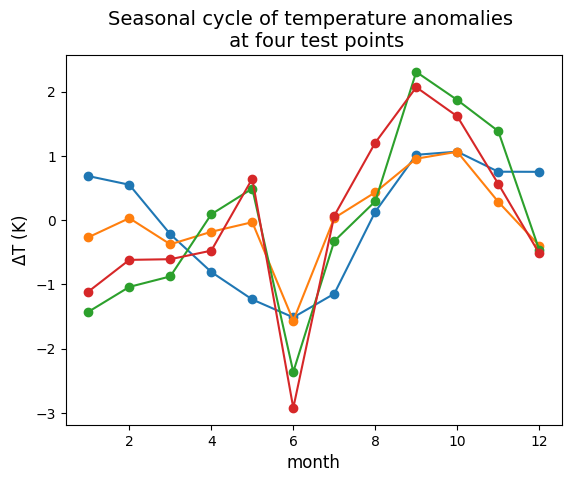

In [22]:
## Test plot seasonal cycle at a few gridpoint locations

# Points to plot seasonal cycle at:
lat_points = (38, 38, 38, 38)
lon_points = (-123.25, -125, -128, -132)

fig = plt.figure()
ax = plt.axes()

for lat, lon in zip(lat_points, lon_points):
    scycle_point = seasonal_cycle.sel(lat=lat, lon=lon)
    ax.plot(scycle_point['month'], scycle_point.values, 'o-')

ax.set_title("Seasonal cycle of temperature anomalies \n at four test points", fontsize=14)
ax.set_xlabel("month", fontsize=12)
ax.set_ylabel(r"$\Delta$T (K)", fontsize=12)

In [ ]:
client.close()

## 2.2 Using Coiled distributed cluster

In [12]:
# Credentials that I'm trying to pass to all the VM's
s3creds = earthaccess.get_s3_credentials(daac='PODAAC')
cluster_env = {**earthaccess.auth_environ(), **s3creds}
del cluster_env['anon']

In [13]:
cluster = coiled.Cluster(
    n_workers=25, 
    region="us-west-2", 
    worker_vm_types="c7g.large", # or can try "m7a.medium"
    scheduler_vm_types="c7g.large", # or can try "m7a.medium"
    #environ=earthaccess.auth_environ(), # This ensures that our EDL credentials are passed to each worker.
    environ=cluster_env, # This ensures that our EDL credentials are passed to each worker.
    ) 
client = cluster.get_client()

Output()

╭──────────────────────────────── Package Info ────────────────────────────────╮
│            ╷                                                                 │
│   Package  │ Note                                                            │
│ ╶──────────┼───────────────────────────────────────────────────────────────╴ │
│   kerchunk │ Wheel built from                                                │
│            │ /opt/coiled/env/.path-deps/kerchunk-0.2.5.post5-py3-none-any.   │
│            │ whl                                                             │
│            ╵                                                                 │
╰──────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────── Not Synced with Cluster ───────────────────────────╮
│             ╷                                                    ╷           │
│   Package   │ Error                                              │ Risk      │
│ ╶───────────┼────────────────────────────────────────────────────┼─────────╴ │
│   libcxxabi │ libcxxabi~=17.0.6 has no install candidate for     │ Warning   │
│             │ Python 3.12 linux-aarch64 on conda-forge           │           │
│             ╵                                                    ╵           │
╰──────────────────────────────────────────────────────────────────────────────╯

Output()

In [14]:
%%time

## --------------------------------------------
## Open dataset with reference file
## --------------------------------------------

s3creds = earthaccess.get_s3_credentials(daac='PODAAC')

data = xr.open_dataset(
    "reference://", engine="zarr", chunks={},
    backend_kwargs={
        "storage_options": {
            "fo": dir_refs_comb + shortname + "_combined.json",
            "remote_protocol": "s3",
            "remote_options": {
                "anon":False, "key": s3creds['accessKeyId'], 
                "secret": s3creds['secretAccessKey'], 
                "token": s3creds['sessionToken']
                }
            },
        "consolidated": False
        }
)
sst = data['analysed_sst']
sst = sst.chunk(chunks={'lat': 300, 'lon': 300, 'time': 200})
sst

CPU times: user 4.32 s, sys: 184 ms, total: 4.51 s
Wall time: 7.89 s


<xarray.DataArray 'analysed_sst' (time: 365, lat: 17999, lon: 36000)> Size: 2TB
dask.array<rechunk-merge, shape=(365, 17999, 36000), dtype=float64, chunksize=(200, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon      (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 3kB 2002-06-01T09:00:00 ... 2003-05-31T09:...
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [15]:
# Region to perform analysis over:
lat_region = (30, 45)
lon_region = (-135, -105)

In [16]:
## ----------------
## Set up analysis
## ----------------
## (Since these are dask arrays, functions calls don't do the computations yet, just set them up)

## Subset to region off U.S.A. west coast:
sst_regional = sst.sel(lat=slice(*lat_region), lon=slice(*lon_region))

## Remove linear warming trend:
p = sst_regional.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst_regional['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst_regional - fit) # xarray is smart enough to subtract along the time dim only.

## Mean seasonal cycle:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")

/opt/coiled/env/lib/python3.12/site-packages/xarray/util/deprecation_helpers.py:140: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  return func(*args, **kwargs)


In [17]:
%%time
## ----------------
## Compute it all!!
## ----------------
seasonal_cycle = seasonal_cycle.compute()
cluster.scale(1)

RuntimeError: Error during deserialization of the task graph. This frequently
occurs if the Scheduler and Client have different environments.
For more information, see
https://docs.dask.org/en/stable/deployment-considerations.html#consistent-software-environments


In [18]:
client.shutdown()
cluster.shutdown()

In [ ]:
## Test plot seasonal cycle at a few gridpoint locations

# Points to plot seasonal cycle at:
lat_points = (38, 38, 38, 38)
lon_points = (-123.25, -125, -128, -132)

fig = plt.figure()
ax = plt.axes()

for lat, lon in zip(lat_points, lon_points):
    scycle_point = seasonal_cycle.sel(lat=lat, lon=lon)
    ax.plot(scycle_point['month'], scycle_point.values, 'o-')

ax.set_title("Seasonal cycle of temperature anomalies \n at four test points", fontsize=14)
ax.set_xlabel("month", fontsize=12)
ax.set_ylabel(r"$\Delta$T (K)", fontsize=12)

## 2.3 Control: Parallel computing on the native netCDF files

In [18]:
multiprocessing.cpu_count()

32

In [19]:
## Local Dask Cluster
client = Client(n_workers=16, threads_per_worker=1)
print(client.cluster)
client.dashboard_link

LocalCluster(1847ada5, 'tcp://127.0.0.1:38599', workers=16, threads=16, memory=122.35 GiB)


'https://cluster-onvfl.dask.host/jupyter/proxy/8787/status'

In [30]:
%%time

## Load files and rechunk SST data:
murdata = xr.open_mfdataset(fobjs[:], parallel=True, chunks={})
sst = murdata["analysed_sst"]
    # Rechunk to get bigger slices along time dimension, since many of the computations
    # operate along that axis:
sst = sst.chunk(chunks={'lat': 300, 'lon': 300, 'time': 200})
sst

CPU times: user 13.1 s, sys: 1.21 s, total: 14.3 s
Wall time: 43.3 s


<xarray.DataArray 'analysed_sst' (time: 365, lat: 17999, lon: 36000)> Size: 2TB
dask.array<rechunk-merge, shape=(365, 17999, 36000), dtype=float64, chunksize=(200, 300, 300), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 2002-06-01T09:00:00 ... 2003-05-31T09:...
  * lat      (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon      (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         AMSRE-REMSS, AVHRR_Pathfinder-PFV5.2-NODC_day, AVHRR_Path...

In [31]:
%%time

## ----------------
## Set up analysis
## ----------------
## (Since these are dask arrays, functions calls don't do the computations yet, just set them up)

## Subset to region off U.S.A. west coast:
sst_regional = sst.sel(lat=slice(*lat_region), lon=slice(*lon_region))

## Remove linear warming trend:
p = sst_regional.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst_regional['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst_regional - fit) # xarray is smart enough to subtract along the time dim only.

## Mean seasonal cycle:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")

## ----------------
## Compute it all!!
## ----------------
seasonal_cycle = seasonal_cycle.compute()

/opt/coiled/env/lib/python3.12/site-packages/xarray/util/deprecation_helpers.py:140: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  return func(*args, **kwargs)
/opt/coiled/env/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 21.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 35.9 s, sys: 4.31 s, total: 40.2 s
Wall time: 1min 41s


Text(0, 0.5, '$\\Delta$T (K)')

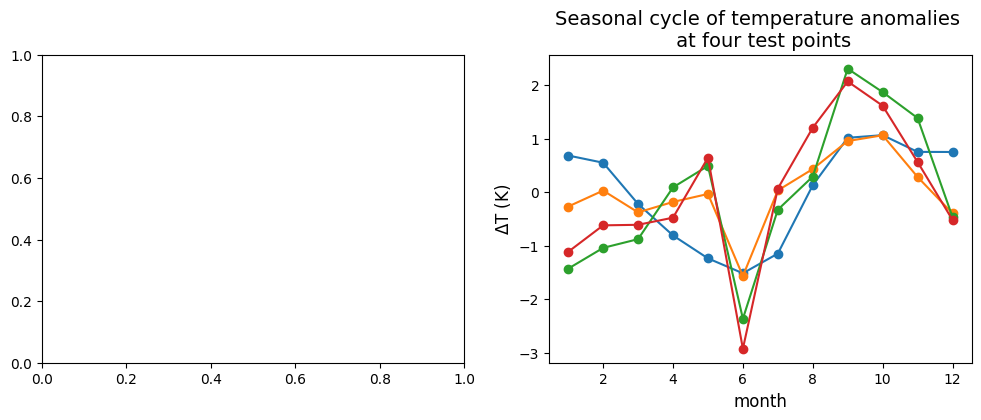

In [32]:
# Points to plot seasonal cycle at:
lat_points = (38, 38, 38, 38)
lon_points = (-123.25, -125, -128, -132)

fig2, axes2 = plt.subplots(1, 2, figsize=(12, 4))

## Replot the map and points from the test file:
#sst_test.sel(lat=slice(*lat_region), lon=slice(*lon_region)).plot(ax=axes2[0], cmap='RdYlBu_r')
#for lat, lon in zip(lat_points, lon_points):
#    axes2[0].scatter(lon, lat)

## Seasonal cycles on another plot
for lat, lon in zip(lat_points, lon_points):
    scycle_point = seasonal_cycle.sel(lat=lat, lon=lon)
    axes2[1].plot(scycle_point['month'], scycle_point.values, 'o-')

axes2[1].set_title("Seasonal cycle of temperature anomalies \n at four test points", fontsize=14)
axes2[1].set_xlabel("month", fontsize=12)
axes2[1].set_ylabel(r"$\Delta$T (K)", fontsize=12)